In [ ]:
import os
import cv2
import math
import numpy as np
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
import matplotlib.patches as patches

4/4 [==============================] - 12s 3s/step


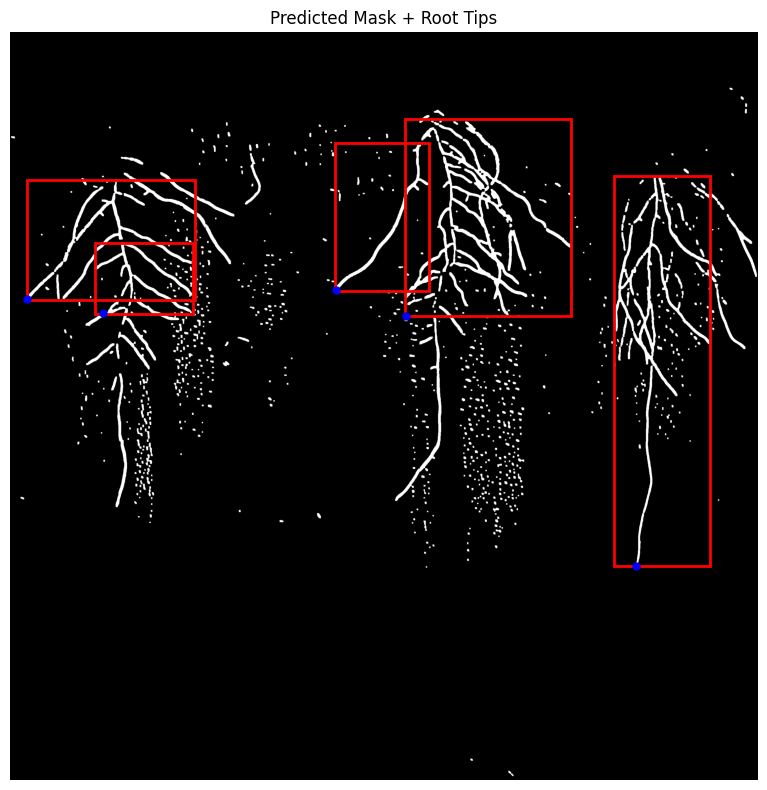

Found 5 root tip(s). Coordinates (in mask):
Tip 1: (x=1422, y=1017)
Tip 2: (x=2246, y=1916)
Tip 3: (x=61, y=958)
Tip 4: (x=335, y=1008)
Tip 5: (x=1168, y=926)


In [4]:
# --- METRIC ---
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return TP / (Positives + K.epsilon())

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return TP / (Pred_Positives + K.epsilon())

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2.0 * ((precision * recall) / (precision + recall + K.epsilon()))

# --- IMAGE CROP ---
def trim_picture(picture):
    picture = picture[:, :-150, :]
    xo, yo, _ = picture.shape
    x_mid = xo // 2
    valid_columns = (picture[x_mid, :, :] >= 100).any(axis=1)
    col_indices = np.where(valid_columns)[0]
    if len(col_indices) == 0:
        return picture, (0, 0), 0
    left_in_cut = col_indices[0]
    trimmed_picture1 = picture[:, col_indices, :]

    y_mid = trimmed_picture1.shape[1] // 2
    valid_rows = (trimmed_picture1[:, y_mid, :] >= 100).any(axis=1)
    row_indices = np.where(valid_rows)[0]
    if len(row_indices) == 0:
        return trimmed_picture1, (0, 0), left_in_cut
    top_in_cut = row_indices[0]
    trimmed_picture2 = trimmed_picture1[row_indices, :, :]

    x, y, _ = trimmed_picture2.shape
    min_dim = min(x, y)
    top_in_trimmed = (x - min_dim) // 2
    left_in_trimmed = (y - min_dim) // 2

    final_crop = trimmed_picture2[
        top_in_trimmed:top_in_trimmed + min_dim,
        left_in_trimmed:left_in_trimmed + min_dim,
        :
    ]

    offset_x_full = top_in_cut + top_in_trimmed
    offset_y_full = left_in_cut + left_in_trimmed

    return final_crop, (offset_x_full, offset_y_full), left_in_cut

# --- IMAGE PADDING ---
def padder(image, patch_size):
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top, bottom = height_padding // 2, height_padding - height_padding // 2
    left, right = width_padding // 2, width_padding - width_padding // 2
    padded = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )
    return padded, (top, bottom, left, right)

# --- MODEL INFERENCE ---
def advanced_image_processing(image_path, model, patch_size=256):
    image_color = cv2.imread(image_path)
    if image_color is None:
        raise ValueError(f"Could not load image at {image_path}")

    image_trimmed, (offset_x, offset_y), left_in_cut = trim_picture(image_color)
    image_gray = cv2.cvtColor(image_trimmed, cv2.COLOR_BGR2GRAY)
    trimmed_shape = image_gray.shape[:2]

    padded, padding_info = padder(image_gray, patch_size)
    padded = np.expand_dims(padded, axis=-1)
    patches_ = patchify(padded, (patch_size, patch_size, 1), step=patch_size)
    reshaped = patches_.reshape(-1, patch_size, patch_size, 1) / 255.0

    predicted = model.predict(reshaped)
    num = int(math.sqrt(predicted.shape[0]))
    predicted_reshaped = predicted.reshape(num, num, patch_size, patch_size)
    mask = unpatchify(predicted_reshaped, padded.shape[:2])
    mask = (mask * 255).astype(np.uint8)
    mask[mask >= 128] = 255
    mask[mask < 128] = 0

    # Smooth and refine
    kernel = np.ones((5, 5), dtype=np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=1)

    # Remove padding
    t, b, l, r = padding_info
    corrected = mask[t:-b or None, l:-r or None]

    final_mask = np.zeros(trimmed_shape, dtype=np.uint8)
    x_off = (trimmed_shape[0] - corrected.shape[0]) // 2
    y_off = (trimmed_shape[1] - corrected.shape[1]) // 2
    final_mask[x_off:x_off + corrected.shape[0], y_off:y_off + corrected.shape[1]] = corrected

    return final_mask, (offset_x, offset_y), left_in_cut

# --- FIND ROOT TIPS ---
def extract_endpoints(mask, n=5, min_area=230):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = [
        (x, y, w, h, cv2.contourArea(c))
        for c in contours if cv2.contourArea(c) >= min_area
        for (x, y, w, h) in [cv2.boundingRect(c)]
    ]
    bboxes = sorted(bboxes, key=lambda b: b[4], reverse=True)[:n]

    centroids = []

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(mask, cmap='gray')

    for (x, y, w, h, _) in bboxes:
        roi = mask[y:y + h, x:x + w]
        M = cv2.moments(roi)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            white_points = np.argwhere(roi == 255)
            if white_points.any():
                idx = np.argmax(white_points[:, 0])
                end_y, end_x = white_points[idx]
                global_x = x + end_x
                global_y = y + end_y
                centroids.append((global_x, global_y))

                ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none'))
                ax.plot(global_x, global_y, 'bo', markersize=5)

    plt.title("Predicted Mask + Root Tips")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return centroids

def estimate_root_length(mask):
    binarized = (mask > 0).astype(np.uint8)
    skeleton = skeletonize(binarized).astype(np.uint8)
    length_px = np.sum(skeleton)  
    px_to_mm = 150 / mask.shape[0]  
    return round(length_px * px_to_mm, 2)

def run_pipeline_on_image(image_path, model_path, output_file="prediction.csv"):
    model = load_model(model_path, custom_objects={"f1": f1})
    mask, offset, _ = advanced_image_processing(image_path, model)
    
    length = estimate_root_length(mask)

    tips = extract_endpoints(mask)
    print(f"Found {len(tips)} root tip(s). Coordinates (in mask):")
    for i, (x, y) in enumerate(tips):
        print(f"Tip {i + 1}: (x={x}, y={y})")

    with open(output_file, "w") as f:
        f.write("filename,length_mm\n")
        f.write(f"{os.path.basename(image_path)},{length}\n")

image_path = "task5_test_image.png"
model_path = r"C:\Users\mstan\OneDrive\Dokumenty\GitHub\2024-25b-fai2-adsai-MonikaStangenberg231648\datalab_tasks\task5\saved_modelr4.h5"    

run_pipeline_on_image(image_path, model_path, output_file="prediction.csv")


Because my model is not perfect, there are gaps in roots of one plant. However, it is detecting bonding boxes correctly (5 the largest object) and it is correctly detecting root tips. 

code adjusted for kaggle competition

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.morphology import skeletonize

# --- METRIC ---
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return TP / (Positives + K.epsilon())

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return TP / (Pred_Positives + K.epsilon())

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2.0 * ((precision * recall) / (precision + recall + K.epsilon()))

# --- IMAGE CROP ---
def trim_picture(picture):
    picture = picture[:, :-150, :]
    xo, yo, _ = picture.shape
    x_mid = xo // 2
    valid_columns = (picture[x_mid, :, :] >= 100).any(axis=1)
    col_indices = np.where(valid_columns)[0]
    if len(col_indices) == 0:
        return picture, (0, 0), 0
    left_in_cut = col_indices[0]
    trimmed_picture1 = picture[:, col_indices, :]

    y_mid = trimmed_picture1.shape[1] // 2
    valid_rows = (trimmed_picture1[:, y_mid, :] >= 100).any(axis=1)
    row_indices = np.where(valid_rows)[0]
    if len(row_indices) == 0:
        return trimmed_picture1, (0, 0), left_in_cut
    top_in_cut = row_indices[0]
    trimmed_picture2 = trimmed_picture1[row_indices, :, :]

    x, y, _ = trimmed_picture2.shape
    min_dim = min(x, y)
    top_in_trimmed = (x - min_dim) // 2
    left_in_trimmed = (y - min_dim) // 2

    final_crop = trimmed_picture2[
        top_in_trimmed:top_in_trimmed + min_dim,
        left_in_trimmed:left_in_trimmed + min_dim,
        :
    ]

    offset_x_full = top_in_cut + top_in_trimmed
    offset_y_full = left_in_cut + left_in_trimmed

    return final_crop, (offset_x_full, offset_y_full), left_in_cut

# --- PADDING ---
def padder(image, patch_size):
    h, w = image.shape[:2]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    top, bottom = height_padding // 2, height_padding - height_padding // 2
    left, right = width_padding // 2, width_padding - width_padding // 2
    padded = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )
    return padded, (top, bottom, left, right)

# --- INFERENCE & MASK RECONSTRUCTION ---
def advanced_image_processing(image_path, model, patch_size=256):
    image_color = cv2.imread(image_path)
    if image_color is None:
        raise ValueError(f"Could not load image at {image_path}")

    image_trimmed, (offset_x, offset_y), left_in_cut = trim_picture(image_color)
    image_gray = cv2.cvtColor(image_trimmed, cv2.COLOR_BGR2GRAY)
    trimmed_shape = image_gray.shape[:2]

    padded, padding_info = padder(image_gray, patch_size)
    padded = np.expand_dims(padded, axis=-1)
    patches_ = patchify(padded, (patch_size, patch_size, 1), step=patch_size)
    reshaped = patches_.reshape(-1, patch_size, patch_size, 1) / 255.0

    predicted = model.predict(reshaped)
    num = int(math.sqrt(predicted.shape[0]))
    predicted_reshaped = predicted.reshape(num, num, patch_size, patch_size)
    mask = unpatchify(predicted_reshaped, padded.shape[:2])
    mask = (mask * 255).astype(np.uint8)
    mask[mask >= 128] = 255
    mask[mask < 128] = 0

    kernel = np.ones((5, 5), dtype=np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=1)

    t, b, l, r = padding_info
    corrected = mask[t:-b or None, l:-r or None]

    final_mask = np.zeros(trimmed_shape, dtype=np.uint8)
    x_off = (trimmed_shape[0] - corrected.shape[0]) // 2
    y_off = (trimmed_shape[1] - corrected.shape[1]) // 2
    final_mask[x_off:x_off + corrected.shape[0], y_off:y_off + corrected.shape[1]] = corrected

    return final_mask

# --- SKELETON LENGTH ---
def estimate_root_length(mask):
    binarized = (mask > 0).astype(np.uint8)
    skeleton = skeletonize(binarized).astype(np.uint8)
    length_px = np.sum(skeleton)
    px_to_mm = 150 / mask.shape[0]
    return round(length_px * px_to_mm, 2)

# --- ROOT TIPS ---
def extract_endpoints(mask, n=5, min_area=230):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = [
        (x, y, w, h, cv2.contourArea(c))
        for c in contours if cv2.contourArea(c) >= min_area
        for (x, y, w, h) in [cv2.boundingRect(c)]
    ]
    bboxes = sorted(bboxes, key=lambda b: b[4], reverse=True)[:n]

    centroids = []
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(mask, cmap='gray')

    for (x, y, w, h, _) in bboxes:
        roi = mask[y:y + h, x:x + w]
        white_points = np.argwhere(roi == 255)
        if white_points.any():
            idx = np.argmax(white_points[:, 0])  
            end_y, end_x = white_points[idx]
            global_x = x + end_x
            global_y = y + end_y
            centroids.append((global_x, global_y))
            ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none'))
            ax.plot(global_x, global_y, 'bo')

    plt.axis("off")
    plt.show()
    return centroids

# --- PROCESS A DIRECTORY ---
def process_directory(input_dir, model_path, output_csv="submission.csv"):
    model = load_model(model_path, custom_objects={"f1": f1})
    results = []

    for fname in sorted(os.listdir(input_dir)):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(input_dir, fname)
            print(f"Processing: {fname}")
            try:
                mask = advanced_image_processing(image_path, model)
                length = estimate_root_length(mask)
                plant_id = os.path.splitext(fname)[0]
                results.append((plant_id, length))
            except Exception as e:
                print(f"Error processing {fname}: {e}")

    df = pd.DataFrame(results, columns=["Plant ID", "Length (px)"])
    df.to_csv(output_csv, index=False)
    print(f"Saved results to {output_csv}")


In [ ]:
input_folder = r"PATH_TO_FOLDER_WITH_IMAGES"
model_path = r"C:\Users\mstan\OneDrive\Dokumenty\GitHub\2024-25b-fai2-adsai-MonikaStangenberg231648\datalab_tasks\task5\saved_modelr4.h5"    
output_csv = "submission.csv"

process_directory(input_folder, model_path, output_csv)
